In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables


/var/folders/05/b94lzz3s50j9t4btks7pf9n00000gn/T/ipykernel_72463/3559592862.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [12]:
# View all of the classes that automap found
Measurement = Base.classes.measurement

In [14]:
# Save references to each table

Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
recent_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date = dt.datetime.strptime(recent_date_str, "%Y-%m-%d")
print("Most recent date in dataset:", recent_date)

Most recent date in dataset: 2017-08-23 00:00:00


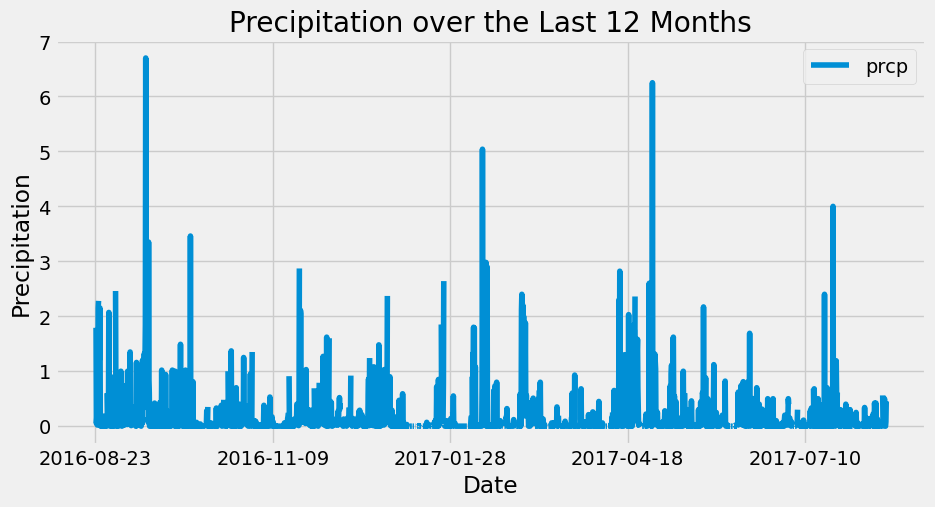

In [22]:
prev_year = recent_date - dt.timedelta(days=365)


prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= prev_year.strftime("%Y-%m-%d")).all()


prcp_df = pd.DataFrame(prcp_data, columns=["date", "prcp"])


prcp_df = prcp_df.sort_values("date")


prcp_df.plot(x="date", y="prcp", figsize=(10, 5), title="Precipitation over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.show()




In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(prcp_df["prcp"].describe())

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(func.count(Station.station)).scalar()
print("Total number of stations:", num_stations)

Total number of stations: 9


In [28]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print("Stations and observation counts:", active_stations)

Stations and observation counts: [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(func.min(Measurement.tobs),
                           func.avg(Measurement.tobs),
                           func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print("Temperature stats (min, avg, max) for most active station:", temp_stats)
most_active_station = active_stations[0][0]
print("Most active station id:", most_active_station)

Temperature stats (min, avg, max) for most active station: [(54.0, 71.66378066378067, 85.0)]
Most active station id: USC00519281


Most active station id: USC00519281


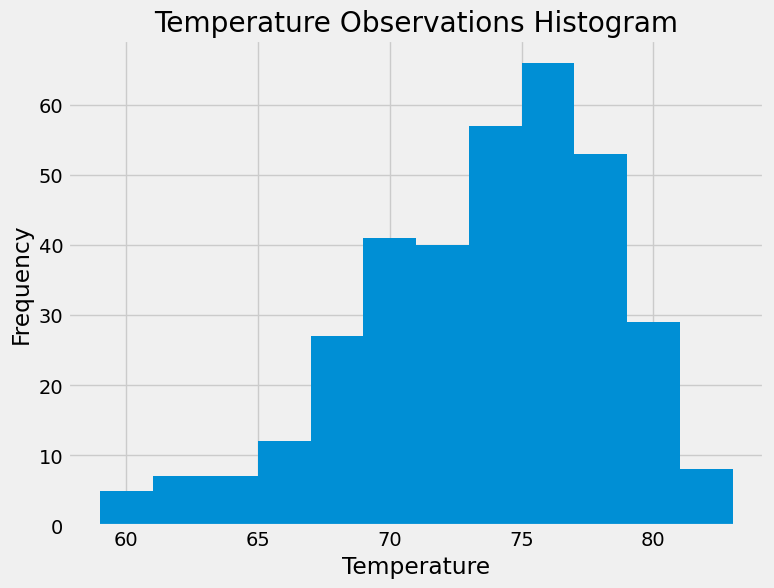

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= prev_year.strftime("%Y-%m-%d")).all()
tobs_df = pd.DataFrame(tobs_data, columns=["date", "tobs"])
tobs_df = tobs_df.sort_values("date")
tobs_df["tobs"].plot(kind="hist", bins=12, figsize=(8, 6), title="Temperature Observations Histogram")
plt.xlabel("Temperature")
plt.show()

# Close Session

In [40]:
# Close Session
session.close()